In [4]:
#%%bash
#pip install sklearn

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [8]:
# load data
education = pd.read_excel("Education.xls", skiprows=4)
employment = pd.read_excel("Unemployment.xls", \
                           sheet_name="Unemployment Med HH Income", skiprows=7)
population = pd.read_csv("cc-est2017-alldata.csv")
electionResults = pd.read_csv("2016_US_County_Level_Presidential_Results.csv")
countyAreas = pd.read_csv('ozone-county-population.csv')

### Clean the data

In [9]:
### education ###

education.drop(education.columns.difference(["FIPS Code",\
    "Percent of adults completing some college or associate's degree, 2014-18"]), 1, inplace=True)
education.rename(columns={"FIPS Code": "FIPS", 
    "Percent of adults completing some college or associate's degree, 2014-18": "Percent with degree"}, inplace=True)
education = education.dropna()

In [10]:
### employment ###

employment.drop(employment.columns.difference(["FIPStxt", "Median_Household_Income_2018"]), 1, inplace=True)
employment.rename(columns={'FIPStxt': 'FIPS', "Median_Household_Income_2018": "Income"}, inplace=True)
employment = employment.dropna()

In [11]:
### election results ###

electionResults.drop(electionResults.columns.difference(["per_dem", "per_gop", "combined_fips"]), \
                    1, inplace=True)
electionResults['margin_R'] = 100*(electionResults['per_gop'] - electionResults['per_dem'])
electionResults.rename(columns={'combined_fips' : 'FIPS'}, inplace=True)
electionResults.drop(electionResults.columns[[0, 1]], 1, inplace=True)
#electionResults

In [12]:
### population ###

population.drop(population.columns.difference(["STATE", "COUNTY", "YEAR", "AGEGRP", "TOT_POP"]), 1, inplace=True)

#Extract total population including all age groups (encoded as 0) from the year 2016 (encoded as 9)
population = population.loc[(population['YEAR'] == 9) & (population['AGEGRP'] == 0)]
population['FIPS'] = population['STATE']*1000 + population['COUNTY']

population.drop(population.columns[[0, 1, 2, 3]], 1, inplace=True)
#print(population)
#population = population.dropna()

In [13]:
### county area ###

# Function that removes commas from a string
def remComma(string):
    return string.replace(',', '')

countyAreas.drop(countyAreas.columns[[2, 3, 4, 5]], 1, inplace=True)
countyAreas.columns.values[2] = "LandArea"
countyAreas["LandArea"] = countyAreas["LandArea"].apply(remComma)
countyAreas["LandArea"] = pd.to_numeric(countyAreas["LandArea"])
countyAreas['FIPS'] = countyAreas['STATE FIPS']*1000 + countyAreas['COUNTY FIPS']
countyAreas.drop(countyAreas.columns[[0, 1]], 1, inplace=True)
#countyDensities.drop(countyDensities.columns[[0, 1]], axis=1, inplace=True)

In [14]:
### combine county population & area to get population density ###
countyDensities = countyAreas.merge(population, on='FIPS')
countyDensities["County Density"] = countyDensities["TOT_POP"]/countyDensities["LandArea"]
countyDensities.drop(countyDensities.columns[[0, 2]], 1, inplace=True)
#countyDensities

In [15]:
# drop USA information from all the data

education.drop(education.head(1).index, inplace=True)
employment.drop(employment.head(1).index, inplace=True)

In [16]:
# examine data
education.head()

,FIPS,Percent with degree
1,1000,29.9
2,1001,28.4
3,1003,31.3
4,1005,25.1
5,1007,24.4


In [17]:
employment.head()

,FIPS,Income
1,1000,49881.0
2,1001,59338.0
3,1003,57588.0
4,1005,34382.0
5,1007,46064.0


In [18]:
#print(employment)

In [19]:
## Merge Data

allData = employment.merge(education, on='FIPS')
allData = allData.merge(countyDensities, on='FIPS')
allData = allData.merge(electionResults, on='FIPS')

In [20]:
allData.head()

,FIPS,Income,Percent with degree,County Density,margin_R
0,1001,59338.0,28.4,92.992349,49.478934
1,1003,57588.0,31.3,130.526537,57.786162
2,1005,34382.0,25.1,29.127245,5.611165
3,1007,46064.0,24.4,36.353444,55.544124
4,1009,50412.0,33.5,89.274415,81.381973


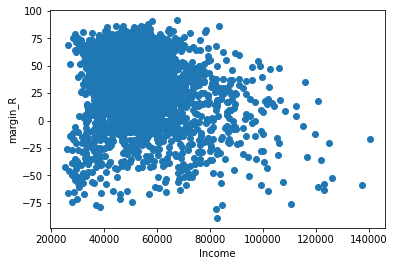

In [21]:
plt.scatter(allData["Income"], allData["margin_R"])
plt.xlabel("Income")
plt.ylabel("margin_R")
plt.show()

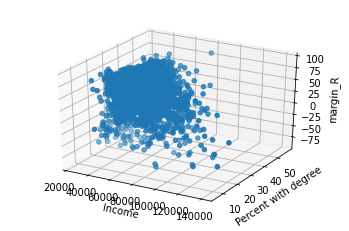

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(allData["Income"], allData["Percent with degree"], allData["margin_R"])
ax.set_xlabel("Income")
ax.set_ylabel("Percent with degree")
ax.set_zlabel("margin_R")
ax.dist = 11
plt.show()

## Linear Regression

In [23]:
# set variables
X1 = allData["Income"].values
X2 = allData["Percent with degree"].values
X3 = allData["County Density"].values
Y = allData["margin_R"].values

In [24]:
X1_train, X1_test, X2_train, X2_test, X3_train, X3_test, Y_train, Y_test = \
    train_test_split(X1, X2, X3, Y, test_size=0.20)

In [28]:
print(X1_train.shape, X2_train.shape, X3_train.shape, Y_train.shape)
print(X1_test.shape, X2_test.shape, X3_test.shape, Y_test.shape)

(2511,) (2511,) (2511,) (2511,)
(628,) (628,) (628,) (628,)


In [31]:
ones = np.ones(len(X1_train))

A_train = np.vstack([ones, X1_train, X2_train, X3_train]).T

W = np.linalg.lstsq(A_train, Y_train)[0]

print("margin_R = %f + %f*income + %f*percent with degrees + %f*county density"%\
     (W[0], W[1], W[2], W[3]))

Y_train_pred = np.matmul(A_train, W)

margin_R = 24.474142 + -0.000451*income + 1.031247*percent with degrees + -0.003179*county density


In [33]:
ones_test = np.ones(len(X1_test))

A_test = np.vstack([ones_test, X1_test, X2_test, X3_test]).T

Y_test_pred = np.matmul(A_test, W)

In [37]:
# SSE
sse_train = sum((Y_train_pred - Y_train)**2)
print("SSE of train: %f"%sse_train)

sse_test = sum((Y_test_pred - Y_test)**2)
print("SSE of test:   %f"%sse_test)

SSE of train: 2117395.067352
SSE of test:   467830.424354


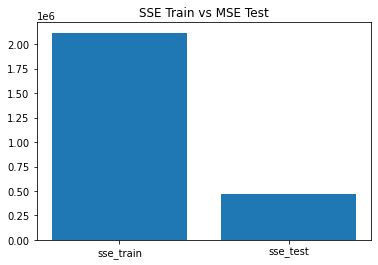

In [41]:
plt.bar(['sse_train', 'sse_test'], [sse_train, sse_test])
plt.title('SSE Train vs MSE Test')
plt.show()

In [39]:
# MSE
mse_train = sse_train / len(X1_train)
mse_test = sse_test / len(X1_test)

print('MSE of train: %f'%mse_train)
print('MSE of test:  %f'%mse_test)

MSE of train: 843.247737
MSE of test:  744.952905


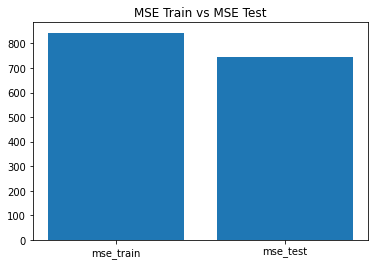

In [40]:
plt.bar(['mse_train', 'mse_test'], [mse_train, mse_test])
plt.title('MSE Train vs MSE Test')
plt.show()